In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from torch.utils.data import TensorDataset, Dataset, DataLoader

from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm
import albumentations as A

## **모델 훈련**

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/ATL/월간 데이콘 제 1회 컴퓨터 비전 학습 경진대회/data/"
train = pd.read_csv(data_path + 'train.csv')

In [ ]:
X_train = train.drop(['id', 'digit', 'letter'], axis=1) / 255
onehot = pd.get_dummies(train['letter'])

X_train = pd.concat([X_train, onehot], axis=1).values
# X_train = X_train.reshape(-1, 28, 28, 1)

y = train['digit']
Y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    Y_train[i, digit] = 1

In [ ]:
print(X_train.shape, Y_train.shape)

(2048, 810) (2048, 10)


In [ ]:
CFG = {'size': 256,
       'batch_size': 64,
       'lr': 0.001,
       'epochs': 100,
       'seed': 42}

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['seed']) # Seed 고정

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 훈련 데이터, 검증 데이터 분리
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=CFG['seed'])

In [ ]:
# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(CFG['size'], CFG['size']),
    A.VerticalFlip(p=0.2),    # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),  # 좌우 대칭 변환
    A.ShiftScaleRotate(       # 이동, 스케일링, 회전 변환
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    ToTensorV2()
])

# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(CFG['size'], CFG['size']),
    ToTensorV2()
])

class ImageDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.image = self.data[:,:784].reshape(-1, 28, 28, 1)
        self.letter = self.data[:,784:]
        self.label = label
        self.transform = transform
        
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, idx):
        image = self.image[idx]
        letter = self.letter[idx].astype('float32')

        if self.transform is not None:
            image = image.astype('float32')
            image = self.transform(image=image)['image']

        if self.label is not None:
            label = self.label.astype('float32')
            label = self.label[idx]
            label = torch.from_numpy(label)
            return image, letter, label
        else:
            return image, letter

train_dataset = ImageDataset(x_train, y_train, transform_train)
val_dataset = ImageDataset(x_valid, y_valid, transform_train)

train_loader = DataLoader(train_dataset, batch_size=CFG['batch_size'], shuffle=True)         # shuffle = True : 에폭마다 랜덤으로 데이터 순서가 바뀌면서 미니배치 구성.
val_loader = DataLoader(val_dataset, batch_size=CFG['batch_size'], shuffle=False)

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
        self.fc1 = nn.Linear(8 * 8 * 256 + 26, 1024, bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2 = nn.Linear(1024, 512, bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)
        
        self.fc3 = nn.Linear(512, 10, bias=True)
        nn.init.xavier_uniform_(self.fc3.weight)

        self.layer5 = nn.Sequential(
            self.fc1,
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            self.fc2,
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            self.fc3,
            nn.LogSoftmax(dim=1)
            )

    def forward(self, x, y):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)   # Flatten
        out = torch.cat((out, y), dim=1)
        out = self.layer5(out)
        return out

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    train_losses = []
    valid_losses = []
    for epoch in range(1, CFG['epochs']+1):
        model.train()
        train_loss = []
        for imgs, letters, labels in tqdm(iter(train_loader)):
            imgs = imgs.to(device)
            letters = letters.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(imgs, letters)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        train_losses.append(_train_loss)
        valid_losses.append(_val_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Accuracy : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model, train_losses, valid_losses

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, letters, labels in tqdm(iter(val_loader)):
            imgs = imgs.to(device)
            letters = letters.to(device)
            labels = labels.to(device)
            
            pred = model(imgs, letters)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.argmax(1).detach().cpu().numpy().tolist()

            val_loss.append(loss.item())

        num = 0
        for i in range(len(preds)):
            if preds[i] == true_labels[i]:
                num += 1

        _val_loss = np.mean(val_loss)
        _val_score = num / len(true_labels)
    
    return _val_loss, _val_score

In [ ]:
model = CNN_Model()
model.eval()
optimizer = optim.AdamW(params = model.parameters(), lr = CFG["lr"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, threshold_mode='abs', min_lr=1e-8, verbose=True)

best_model, train_loss, valid_loss = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1], Train Loss : [2.56714] Val Loss : [2.89927] Val Accuracy : [0.09512]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2], Train Loss : [2.17280] Val Loss : [3.19518] Val Accuracy : [0.11463]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3], Train Loss : [1.88829] Val Loss : [1.95109] Val Accuracy : [0.36341]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4], Train Loss : [1.73332] Val Loss : [1.84173] Val Accuracy : [0.38049]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5], Train Loss : [1.58543] Val Loss : [1.44445] Val Accuracy : [0.53659]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6], Train Loss : [1.47422] Val Loss : [1.36156] Val Accuracy : [0.54390]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7], Train Loss : [1.38360] Val Loss : [1.31184] Val Accuracy : [0.58049]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8], Train Loss : [1.30384] Val Loss : [1.24129] Val Accuracy : [0.59756]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9], Train Loss : [1.30840] Val Loss : [1.38482] Val Accuracy : [0.55854]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10], Train Loss : [1.22964] Val Loss : [1.32918] Val Accuracy : [0.53415]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11], Train Loss : [1.15476] Val Loss : [1.27918] Val Accuracy : [0.56341]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12], Train Loss : [1.13338] Val Loss : [1.11164] Val Accuracy : [0.61951]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13], Train Loss : [1.10520] Val Loss : [1.38080] Val Accuracy : [0.56098]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14], Train Loss : [1.12014] Val Loss : [1.30991] Val Accuracy : [0.55366]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15], Train Loss : [1.04556] Val Loss : [1.11315] Val Accuracy : [0.64634]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [16], Train Loss : [1.00476] Val Loss : [1.19323] Val Accuracy : [0.59268]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [17], Train Loss : [1.02242] Val Loss : [1.05278] Val Accuracy : [0.65122]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.99389] Val Loss : [1.05192] Val Accuracy : [0.64390]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.92824] Val Loss : [1.00396] Val Accuracy : [0.66098]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.90819] Val Loss : [0.94509] Val Accuracy : [0.65854]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.87929] Val Loss : [1.15271] Val Accuracy : [0.65122]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.86458] Val Loss : [1.08814] Val Accuracy : [0.65122]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.84236] Val Loss : [1.41560] Val Accuracy : [0.57317]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.82894] Val Loss : [0.95284] Val Accuracy : [0.65366]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.83049] Val Loss : [0.95830] Val Accuracy : [0.67561]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.80591] Val Loss : [1.04885] Val Accuracy : [0.66098]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.81882] Val Loss : [0.91738] Val Accuracy : [0.70244]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.74743] Val Loss : [1.11125] Val Accuracy : [0.64634]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.80619] Val Loss : [0.97042] Val Accuracy : [0.70000]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.74048] Val Loss : [0.86897] Val Accuracy : [0.70000]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.70916] Val Loss : [1.01635] Val Accuracy : [0.68537]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.77966] Val Loss : [1.09490] Val Accuracy : [0.68049]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.71057] Val Loss : [0.97196] Val Accuracy : [0.68049]
Epoch 00033: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.67361] Val Loss : [0.86384] Val Accuracy : [0.69268]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.67793] Val Loss : [0.80004] Val Accuracy : [0.73902]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.64169] Val Loss : [0.81926] Val Accuracy : [0.72439]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.61263] Val Loss : [0.96237] Val Accuracy : [0.69024]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.55297] Val Loss : [0.87503] Val Accuracy : [0.71220]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.61143] Val Loss : [0.82848] Val Accuracy : [0.70488]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.55147] Val Loss : [0.82848] Val Accuracy : [0.72927]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [41], Train Loss : [0.54770] Val Loss : [0.84893] Val Accuracy : [0.70732]
Epoch 00041: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [42], Train Loss : [0.56948] Val Loss : [0.80397] Val Accuracy : [0.72683]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [43], Train Loss : [0.58962] Val Loss : [0.84291] Val Accuracy : [0.73659]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [44], Train Loss : [0.53808] Val Loss : [0.82832] Val Accuracy : [0.72683]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [45], Train Loss : [0.55363] Val Loss : [0.82251] Val Accuracy : [0.70976]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [46], Train Loss : [0.54395] Val Loss : [0.76522] Val Accuracy : [0.73902]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [47], Train Loss : [0.51271] Val Loss : [0.80763] Val Accuracy : [0.72195]
Epoch 00047: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [48], Train Loss : [0.51716] Val Loss : [0.81278] Val Accuracy : [0.73415]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [49], Train Loss : [0.47145] Val Loss : [0.78124] Val Accuracy : [0.73659]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [50], Train Loss : [0.49887] Val Loss : [0.78303] Val Accuracy : [0.73902]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [51], Train Loss : [0.52353] Val Loss : [0.83874] Val Accuracy : [0.73659]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [52], Train Loss : [0.51582] Val Loss : [0.75469] Val Accuracy : [0.77073]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [53], Train Loss : [0.49749] Val Loss : [0.73945] Val Accuracy : [0.75854]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [54], Train Loss : [0.51672] Val Loss : [0.75332] Val Accuracy : [0.74146]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [55], Train Loss : [0.47731] Val Loss : [0.82619] Val Accuracy : [0.72195]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [56], Train Loss : [0.46985] Val Loss : [0.82974] Val Accuracy : [0.73415]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [57], Train Loss : [0.48453] Val Loss : [0.76402] Val Accuracy : [0.75610]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [58], Train Loss : [0.47647] Val Loss : [0.76202] Val Accuracy : [0.73902]
Epoch 00058: reducing learning rate of group 0 to 6.2500e-05.


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [59], Train Loss : [0.46224] Val Loss : [0.78222] Val Accuracy : [0.75366]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [60], Train Loss : [0.45026] Val Loss : [0.77018] Val Accuracy : [0.72927]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [61], Train Loss : [0.44969] Val Loss : [0.73851] Val Accuracy : [0.75610]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [62], Train Loss : [0.46909] Val Loss : [0.69710] Val Accuracy : [0.76585]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [63], Train Loss : [0.43698] Val Loss : [0.74518] Val Accuracy : [0.76829]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [64], Train Loss : [0.43107] Val Loss : [0.77865] Val Accuracy : [0.74878]
Epoch 00064: reducing learning rate of group 0 to 3.1250e-05.


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [65], Train Loss : [0.45139] Val Loss : [0.74790] Val Accuracy : [0.75366]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [66], Train Loss : [0.43291] Val Loss : [0.79680] Val Accuracy : [0.74878]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [67], Train Loss : [0.45551] Val Loss : [0.76634] Val Accuracy : [0.74146]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [68], Train Loss : [0.44814] Val Loss : [0.72078] Val Accuracy : [0.75366]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [69], Train Loss : [0.45643] Val Loss : [0.78998] Val Accuracy : [0.73902]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [70], Train Loss : [0.38960] Val Loss : [0.73474] Val Accuracy : [0.75610]
Epoch 00070: reducing learning rate of group 0 to 1.5625e-05.


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [71], Train Loss : [0.46335] Val Loss : [0.81459] Val Accuracy : [0.72439]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [72], Train Loss : [0.45357] Val Loss : [0.75065] Val Accuracy : [0.74390]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [73], Train Loss : [0.45379] Val Loss : [0.82902] Val Accuracy : [0.74390]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [74], Train Loss : [0.43923] Val Loss : [0.76216] Val Accuracy : [0.73659]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [75], Train Loss : [0.42939] Val Loss : [0.78217] Val Accuracy : [0.74390]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [76], Train Loss : [0.46140] Val Loss : [0.74273] Val Accuracy : [0.76341]
Epoch 00076: reducing learning rate of group 0 to 7.8125e-06.


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [77], Train Loss : [0.44771] Val Loss : [0.76882] Val Accuracy : [0.75366]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [78], Train Loss : [0.48227] Val Loss : [0.73536] Val Accuracy : [0.76829]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [79], Train Loss : [0.43002] Val Loss : [0.74002] Val Accuracy : [0.76341]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [80], Train Loss : [0.43385] Val Loss : [0.77320] Val Accuracy : [0.76098]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [81], Train Loss : [0.43298] Val Loss : [0.81804] Val Accuracy : [0.72927]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [82], Train Loss : [0.44482] Val Loss : [0.72617] Val Accuracy : [0.76341]
Epoch 00082: reducing learning rate of group 0 to 3.9063e-06.


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [83], Train Loss : [0.43899] Val Loss : [0.76336] Val Accuracy : [0.74390]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [84], Train Loss : [0.45052] Val Loss : [0.74410] Val Accuracy : [0.74634]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [85], Train Loss : [0.40326] Val Loss : [0.80132] Val Accuracy : [0.74634]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [86], Train Loss : [0.47253] Val Loss : [0.73654] Val Accuracy : [0.77073]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [87], Train Loss : [0.42791] Val Loss : [0.73540] Val Accuracy : [0.74634]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [88], Train Loss : [0.44530] Val Loss : [0.76908] Val Accuracy : [0.73171]
Epoch 00088: reducing learning rate of group 0 to 1.9531e-06.


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [89], Train Loss : [0.44508] Val Loss : [0.72504] Val Accuracy : [0.75366]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [90], Train Loss : [0.45016] Val Loss : [0.79598] Val Accuracy : [0.74146]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [91], Train Loss : [0.42114] Val Loss : [0.74709] Val Accuracy : [0.73902]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [92], Train Loss : [0.43622] Val Loss : [0.75883] Val Accuracy : [0.74390]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [93], Train Loss : [0.43528] Val Loss : [0.72539] Val Accuracy : [0.75854]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [94], Train Loss : [0.48027] Val Loss : [0.76410] Val Accuracy : [0.74390]
Epoch 00094: reducing learning rate of group 0 to 9.7656e-07.


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [95], Train Loss : [0.41235] Val Loss : [0.74870] Val Accuracy : [0.75122]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [96], Train Loss : [0.46201] Val Loss : [0.69705] Val Accuracy : [0.76341]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [97], Train Loss : [0.46626] Val Loss : [0.77943] Val Accuracy : [0.75610]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [98], Train Loss : [0.46602] Val Loss : [0.74663] Val Accuracy : [0.74878]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [99], Train Loss : [0.42635] Val Loss : [0.72590] Val Accuracy : [0.77805]


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [100], Train Loss : [0.40718] Val Loss : [0.81739] Val Accuracy : [0.72683]


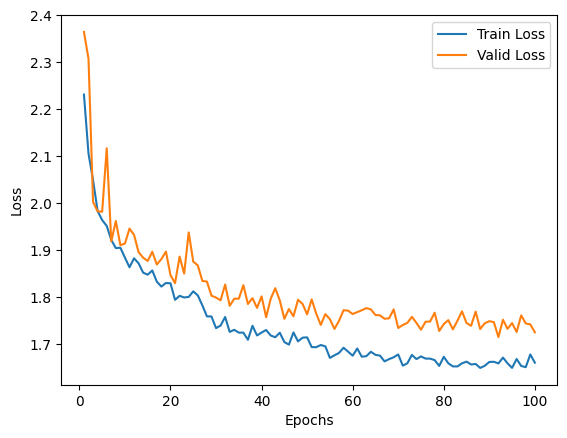

In [ ]:
plt.plot(range(1, CFG['epochs']+1), train_loss, label='Train Loss')
plt.plot(range(1, CFG['epochs']+1), valid_loss, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
## TTA

test = pd.read_csv(data_path + 'test.csv')
test_onehot = pd.get_dummies(test['letter'])
test = test.drop(['id', 'letter'], axis=1) / 255
test = pd.concat([test, test_onehot], axis=1).values

test_TTA = ImageDataset(test, None, transform_train)
test_loader = DataLoader(test_TTA, batch_size=CFG['batch_size'], shuffle=False)

def inference(model, test_loader, device):
    model.eval()
    preds = np.zeros((len(test), 10))
    num_TTA = 10

    for _ in range(num_TTA):
      with torch.no_grad():
        for idx, (imgs, letters) in enumerate(tqdm(iter(test_loader))):
            imgs = imgs.to(device)
            letters = letters.to(device)
            pred = model(imgs, letters)
            
            preds_part = pred.detach().cpu().numpy()
            if idx == len(test_loader) - 1 and len(imgs) != CFG['batch_size']:
              idx_size = len(imgs)
              preds[idx*CFG['batch_size']: idx*CFG['batch_size']+idx_size] += preds_part[:idx_size]
            else:
              preds[idx*CFG['batch_size']:(idx+1)*CFG['batch_size']] += preds_part
    
    preds = preds / num_TTA

    return preds

preds = inference(best_model, test_loader, device)
preds = preds.argmax(1)

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

In [ ]:
# No TTA

test = pd.read_csv(data_path + 'test.csv')
test_onehot = pd.get_dummies(test['letter'])
test = test.drop(['id', 'letter'], axis=1) / 255
test = pd.concat([test, test_onehot], axis=1).values

test_TTA = ImageDataset(test, None, transform_test)
test_loader = DataLoader(test_TTA, batch_size=CFG['batch_size'], shuffle=False)

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs, letters in tqdm(iter(test_loader)):
            imgs = imgs.to(device)
            letters = letters.to(device)

            pred = model(imgs, letters)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    return preds

preds = inference(best_model, test_loader, device)

  0%|          | 0/320 [00:00<?, ?it/s]

In [ ]:
submit = pd.read_csv(data_path + 'submission.csv')
submit['digit'] = preds
submit.to_csv('./upgrade_sumit.csv', index=False)

In [ ]:
submit['digit'].value_counts()

1    2421
0    2173
5    2101
3    2083
9    2077
4    2031
6    2027
2    1924
8    1920
7    1723
Name: digit, dtype: int64

In [ ]:
submit['digit'].value_counts() # Baseline

9    2321
1    2231
0    2074
7    2062
4    1994
3    1992
5    1984
2    1959
6    1957
8    1906
Name: digit, dtype: int64